# Liver Model Construction: Notebook-Glycogenolysis

## Setup workflow

### Import packages

In [32]:
import os
import warnings
from cobra.io.json import load_json_model as load_json_cobra_model
import escher
import mass
import numpy as np
import pandas as pd
import sympy as sym
from cobra import Model, Reaction, Metabolite
import cobra.test
from os.path import join
from mass.util import qcqa_model
from cobra import DictList
from mass import (
    MassConfiguration, MassMetabolite, MassModel,
    MassReaction, Simulation, UnitDefinition)
from mass.io.json import save_json_model as save_json_mass_model
from mass.visualization import plot_comparison, plot_time_profile
mass_config = MassConfiguration()
mass_config.irreversible_Keq = float("inf")
print("MASSpy version: {0}".format(mass.__version__))
from six import iteritems
import matplotlib.pyplot as plt
from mass.thermo import (
    ConcSolver, sample_concentrations,
    update_model_with_concentration_solution)

MASSpy version: 0.1.1


## Set paths and constants

In [33]:
seed = int(4)
#increase number of models from before
n_models = 3

mass_config = MassConfiguration()
mass_config.solver = "cplex"

### Directory paths

In [34]:
model_dir = os.path.abspath("../mass_user/models")
maps_dir = os.path.abspath("../mass_user/maps")
data_dir = os.path.abspath("../mass_user/data")

In [35]:
# model_dir = os.path.abspath(".../MASSliver/models")
# maps_dir = os.path.abspath(".../MASSliver/models/maps")
# data_dir = os.path.abspath(".../MASSliver/data/interim")

In [36]:
# Allow Escher to close without pop-up
escher.rc['never_ask_before_quit'] = True


### Load COBRA model

In [37]:
core_model=load_json_cobra_model(filename=os.path.join(model_dir,"CoreModel.json"))
core_model

Name,None
Memory address,0x07fe685a9d0d0
Number of metabolites,178
Number of reactions,187
Number of groups,0
Objective expression,1.0*ATPM - 1.0*ATPM_reverse_5b752
Compartments,"m, i, c, r,"


In [38]:
trial = Model('Smaller Glycogenolysis') 
trial

Name,Smaller Glycogenolysis
Memory address,0x07fe685907050
Number of metabolites,0
Number of reactions,0
Number of groups,0
Objective expression,0
Compartments,


In [39]:
# core_model.reactions.EX_glc__D_c.remove_from_model()

In [40]:
## adding reactions from Recon3D
R3D=load_json_cobra_model(filename=os.path.join(model_dir,"Recon3D.json"))

In [41]:
# ## adding reactions from glycogenloysis 
# gly=load_json_cobra_model(filename=os.path.join(model_dir,"Glycogenolysis.json"))

In [42]:
# r_list=[
   
# #     'EX_pyr_e',
# #     'EX_lac__L_e'  
# ]
# for rid in r_list:
#     reaction = core_model.reactions.get_by_id(rid)
#     trial.add_reactions([reaction])  
r_list_2=[
     'HEX1',
    'PFK',
    'FBP',
    'G6PPer',
    'G6Pter',
    'GLCter',
    'PGI', 
    'H2Oter',
    'PIter',
    'H2Ot',
    'PIt',
    'EX_glc__D_e',
    'GLCt1',
    'Ht'
]
for rid in r_list_2:
    reaction = R3D.reactions.get_by_id(rid)
    trial.add_reactions([reaction])

In [43]:
## change after double checking this, maybe not needed to be added to core?

# f=gly.reactions.SK_f6p_c
# g= gly.reactions.SK_g6p_c

# new_r_list=[
#     f,
#     g    
# ]


In [44]:
# for x in new_r_list:
#     c= x
#     trial.add_reaction(c)

In [45]:
# create exchange reaction
fdp=R3D.metabolites.get_by_id('fdp_c')
atp=R3D.metabolites.get_by_id('atp_c')
adp=R3D.metabolites.get_by_id('adp_c')
h2o=R3D.metabolites.get_by_id('h2o_e')
pie=R3D.metabolites.get_by_id('pi_e')
he=R3D.metabolites.get_by_id('h_e')

In [46]:
# create exchange reaction
trial.add_boundary(atp, type="sink")
trial.add_boundary(adp, type="sink")
trial.add_boundary(fdp, type="sink")
trial.add_boundary(h2o, type="exchange")
trial.add_boundary(pie, type="exchange")
trial.add_boundary(he, type="exchange")

Reaction identifier,EX_h_e
Name,H+ exchange
Memory address,0x07fe684eeca90
Stoichiometry,h_e <=> H+ <=>
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [47]:
trial.reactions

[<Reaction HEX1 at 0x7fe657eca950>,
 <Reaction PFK at 0x7fe6780d6c90>,
 <Reaction FBP at 0x7fe657f7ae10>,
 <Reaction G6PPer at 0x7fe678d31f90>,
 <Reaction G6Pter at 0x7fe65720cf90>,
 <Reaction GLCter at 0x7fe678cd8290>,
 <Reaction PGI at 0x7fe6581a5d90>,
 <Reaction H2Oter at 0x7fe678cf2fd0>,
 <Reaction PIter at 0x7fe678bc9f90>,
 <Reaction H2Ot at 0x7fe6781d7d50>,
 <Reaction PIt at 0x7fe678a8bc10>,
 <Reaction EX_glc__D_e at 0x7fe6593f5d90>,
 <Reaction GLCt1 at 0x7fe657093c10>,
 <Reaction Ht at 0x7fe6582289d0>,
 <Reaction SK_atp_c at 0x7fe685157710>,
 <Reaction SK_adp_c at 0x7fe685157690>,
 <Reaction SK_fdp_c at 0x7fe68514a3d0>,
 <Reaction EX_h2o_e at 0x7fe6850706d0>,
 <Reaction EX_pi_e at 0x7fe684e1f050>,
 <Reaction EX_h_e at 0x7fe684eeca90>]

## View Escher map

In [48]:
#view all the reactions that we need build
escher_builder = escher.Builder(
    model=trial,
    map_json=os.path.join(
        maps_dir, ".".join((
            "Glycogenolysis", "map", "json"))
    ),
    highlight_missing=True)

escher_builder


Builder(highlight_missing=True, never_ask_before_quit=True)

### Loading Measured Fluxes

In [49]:
def load_data(filepath, sheet_name):
    """Load Liver data from an excel sheet"""
    df = pd.read_excel(engine='openpyxl',
        io=filepath,
        sheet_name=sheet_name,
        index_col=0)
    return df

In [50]:
#define data sheet as latest data sheet
data_sheet=os.path.join(data_dir,"2.9-srp-data-collection.xlsx")

flux_df = load_data(
    filepath=data_sheet,
    sheet_name="Fluxes").drop("Fasting Time", axis=1).drop("Additional Notes", axis=1)
flux_df = flux_df.dropna() #drops rows with NaN
flux_df


,Flux (mmol/gDW*hr)
ID,
G6PPer,0.001682
HEX1,0.000000
GLCt1,-0.001682
PGI,-0.002919
EX_glc__D_e,0.085498
FBP,0.002919
PFK,0.000000


In [63]:
v_vars = []
v_data = []

# How much flux to allow through irreversible reaction pairs
# e.g, PFK/FBP & reverse_flux_percent = 0.1, raise both fluxes by 10% of non-zero flux value
reverse_flux_percent = 0.1
irreversible_enzyme_pairs = ["PFK", "FBP"]
irreversible_enzyme_pairs2 = ["HEX1", "G6PPer"]


In [64]:
for rid, flux in flux_df.itertuples():
    reaction = trial.reactions.get_by_id(rid)
    #reaction.bounds = (flux, flux)
    #set bounds for all boundary reactions 
    #uptake --> (-value, 1000)
    #secretion --> (-1000 --> value)
    #reversible --> (-1000,1000)
#     if (rid == "EX_lac__L_e"): #uptake
#         pass
# #         reaction = trial.reactions.get_by_id(rid)
# #         reaction.bounds = (0,1000) 
    if (rid == "EX_glc__L_e"): #secretion
        reaction = trial.reactions.get_by_id(rid)
        reaction.bounds = (0.085498214,0.085498214) ## restricitng glucose  HEPATOKIN Supplemental 15 

#     elif (rid == "EX_pyr_e"): #uptake
#         reaction = trial.reactions.get_by_id(rid)
#         reaction.bounds = (0, 1000) 
#     elif (rid == "SK_f6p_c"): 
#         reaction = trial.reactions.get_by_id(rid)
#         reaction.bounds = (-1000, 0)
#     elif (rid == "SK_g6p_c"): 
#         reaction = trial.reactions.get_by_id(rid)
#         reaction.bounds = (-1000, 0)
#     elif (rid == "EX_glygn2_c"): #uptake
#         reaction = core_model.reactions.get_by_id(rid)
#         reaction.bounds = (-1, 1000) 
    for irreversible_enzyme_pair in irreversible_enzyme_pairs:
        if rid in irreversible_enzyme_pair:
            flux1, flux2 = flux_df.loc[irreversible_enzyme_pairs, "Flux (mmol/gDW*hr)"].values
            if flux1 == 0:
                flux += reverse_flux_percent * flux2 # mmol*gDW^-1*hr^-1
            if flux2 == 0:
                flux += reverse_flux_percent * flux1 # mmol*gDW^-1*hr^-1
    for irreversible_enzyme_pair in irreversible_enzyme_pairs2:
        if rid in irreversible_enzyme_pair:
            flux3, flux4 = flux_df.loc[irreversible_enzyme_pairs2, "Flux (mmol/gDW*hr)"].values
            if flux3 == 0:
                flux += reverse_flux_percent * flux4 # mmol*gDW^-1*hr^-1
            if flux4 == 0:
                flux += reverse_flux_percent * flux3 # mmol*gDW^-1*hr^-1
                
    #address irreversible enzyme pair boundary reactions if necessary

    print(rid, flux)

    v_vars.append(sym.Symbol(rid))
    v_data.append(flux)

G6PPer 0.0018502083831
HEX1 0.00016820076210000002
GLCt1 -0.001682007621
PGI -0.002918552036
EX_glc__D_e 0.0854982138575
FBP 0.0032104072395999998
PFK 0.0002918552036


In [65]:
# Make symbolic for optlang objective 
v_vars = sym.Matrix(v_vars)
v_data = sym.Matrix(v_data)

F = sym.Matrix(2 * sym.eye(len(v_vars)))

objective = 0.5 * v_vars.T * F * v_vars  - (2 * v_data).T * v_vars
trial.objective = objective[0]
trial.objective_direction = "min"

flux_solution = trial.optimize()

In [66]:
# ab=pd.DataFrame(flux_solution.fluxes)
# ab.to_excel("output.xlsx")
flux_solution.fluxes

HEX1           0.000000
PFK            0.000648
FBP            0.002854
G6PPer         0.002206
G6Pter         0.002206
GLCter        -0.002206
PGI           -0.002206
H2Oter         0.002206
PIter          0.002206
H2Ot           0.005061
PIt            0.005061
EX_glc__D_e    0.002206
GLCt1         -0.002206
Ht            -0.000648
SK_atp_c      -0.000648
SK_adp_c       0.000648
SK_fdp_c      -0.002206
EX_h2o_e      -0.005061
EX_pi_e        0.005061
EX_h_e         0.000648
Name: fluxes, dtype: float64

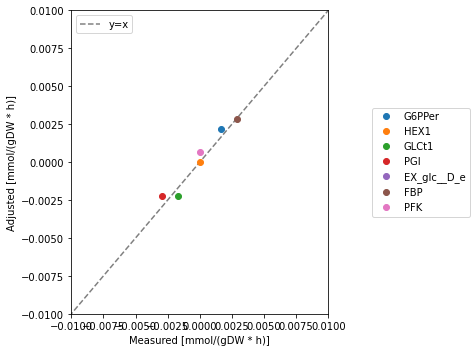

In [67]:
flux_comparison_fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
plot_comparison(
    x=flux_df["Flux (mmol/gDW*hr)"], y=flux_solution, compare="fluxes",
    observable=[rid for rid in flux_df.index], ax=ax,
    legend="right outside", plot_function="plot",
    xlim=(-0.01,0.01), ylim=(-0.01, 0.01),
    xy_line=True,
    xy_legend="best", xlabel="Measured [mmol/(gDW * h)]", ylabel="Adjusted [mmol/(gDW * h)]")

flux_comparison_fig.tight_layout()
#check directionality 


## Create MASS model

In [68]:
glycogenolysis = MassModel("Glycogenolysis", array_type='DataFrame', dtype=np.int64)
glycogenolysis

Name,Glycogenolysis
Memory address,0x07fe684802090
Stoichiometric Matrix,0x0
Matrix Rank,0
Number of metabolites,0
Initial conditions defined,0/0
Number of reactions,0
Number of genes,0
Number of enzyme modules,0
Number of groups,0
Objective expression,0


### Define reactions

In [69]:
#add reactions one at a time
##G6PPer, HEX1, GLCt1, PGI

# EX_glc__D_e    0.001682

# SK_f6p_c      -0.001682
# SK_g6p_c       0.000000
# SK_atp_c      -0.000168
# SK_adp_c       0.000168
# EX_h2o_e      -0.001850
# EX_pi_e        0.001850
# EX_h_e         0.000168


reaction_list=[]
reaction_list = ['HEX1',
                 'PFK',
                 'FBP',
                 'GLCt1',
                 'G6Pter',
                 'G6PPer',
                 'GLCter',
#                  'EX_glc__D_e',
                'PGI',
                 'H2Oter',
                'PIter',
                'H2Ot',
                'PIt',
                'Ht'
#                 #'FBP',
#                 'PFK',
#                 'FBA',
#                 'TPI',
#                 'GAPD',
#                 'PGK',
#                 'PGM',
#                 'ENO',
#                 #'PEPtm',
#                 #'PEPCKm',
#                 #'LDH_L',
#                 'PYK'
#                 #'PCm',
#                 #'PYRt2m'
                ]


In [70]:
# Convert cobra.Reactions to mass.MassReactions
for rid in reaction_list:
    reaction = trial.reactions.get_by_id(rid)
    glycogenolysis.add_reactions([MassReaction(reaction)])

##  Set Fluxes

In [71]:
for reaction, flux in flux_solution[reaction_list].iteritems():
    reaction = glycogenolysis.reactions.get_by_id(reaction)
    reaction.steady_state_flux = flux * 1278.605 / 1000 
    # mmol/gdW*hr --> mmol/L * hr ---> mol/L*hr
    print("{0}: {1}".format(reaction.flux_symbol_str,
                            reaction.steady_state_flux))

v_HEX1: 0.0
v_PFK: 0.0008284973680377127
v_FBP: 0.003649512903150023
v_GLCt1: -0.0028210155351123104
v_G6Pter: 0.0028210155351123104
v_G6PPer: 0.0028210155351123104
v_GLCter: -0.0028210155351123104
v_PGI: -0.0028210155351123104
v_H2Oter: 0.0028210155351123104
v_PIter: 0.0028210155351123104
v_H2Ot: 0.006470528438262334
v_PIt: 0.006470528438262334
v_Ht: -0.0008284973680377127


## Set Keqs

In [72]:
# Load equilibrium constants
Keq_df = pd.read_excel(engine='openpyxl',
    io=data_sheet,
    sheet_name="Keqs",
    index_col=0).drop("Reference", axis=1).drop("Stoichiometry", axis=1).drop('Keq unit', axis=1)

Keq_df = Keq_df.dropna() #drops rows with NaN
Keq_df

,Equlibrium Constant
Reaction,
GLCt1,1.000000
HEX1,28.077000
G6PPer,0.278000
PGI,0.925000
G6Pter,1.000000
GLCter,1.000000
PFK,514.595916
FBP,154.661691


In [73]:
Keq_list =[]
#setting exchange constants as 1

transport= [
    'H2Oter',
    'PIter',
    'H2Ot',
    'PIt',
    'Ht',
    'GLCter',
    'G6Pter'
]
for x in transport:
    a=glycogenolysis.reactions.get_by_id(x)
    a.Keq=1

glycogenolysis.reactions.G6PPer.Keq=1/0.278 ## value seems to be inverted

for rid, Keq in Keq_df.itertuples():
    if rid in reaction_list: 
        reaction = glycogenolysis.reactions.get_by_id(rid)
        reaction.Keq = Keq
        Keq_list.append(reaction.Keq)
        print("{0}: {1}".format(reaction.Keq_str, Keq))
glycogenolysis.reactions.G6PPer.Keq=1/0.278

Keq_GLCt1: 1.0
Keq_HEX1: 28.077
Keq_G6PPer: 0.278
Keq_PGI: 0.925
Keq_G6Pter: 1.0
Keq_GLCter: 1.0
Keq_PFK: 514.5959163
Keq_FBP: 154.6616914


## Obtain Concentrations

In [74]:
#Load Concentration Data
conc_df = load_data(
    filepath=data_sheet,
    sheet_name="Concentrations").drop("Concentration (mM)", axis=1)
conc_df = conc_df.drop("Additional Notes", axis=1)
conc_df = conc_df.dropna() #drops rows with NaN
conc_df

,Name,Concentration(M)
ID,,
glc__D_c,D-Glucose,0.010483
atp_c,ATP C10H12N5O13P3,0.004727
adp_c,ADP C10H12N5O10P2,0.001995
g6p_c,D-Glucose 6-phosphate,0.000140
g6p_r,D-Glucose 6-phosphate,0.000387
pi_r,Phosphate,0.009744
glc__D_r,D-Glucose,0.010483
f6p_c,D-Fructose-6-phosphate,0.000127
glc__D_e,D-Glucose,0.000000


In [80]:
#Set Concentrations

metabolite_list = [
                    # HEX1    
                    'glc__D_c',
                    'g6p_c',
                    'adp_c',
                    'atp_c',
                    #'pi_c',
                    'h_c',

                    # GLCt1
                    'glc__D_e',

                    # #G6Pter
                    'g6p_r',

                    # #G6PPer , #GLCter
                    'h2o_r',
                    'glc__D_r',
                    'pi_r',
#                     'PGI',
'f6p_c', 
#                     'H2Oter',
'h2o_c',

#                     'PIter',
'pi_r',
'pi_c',

#                     'H2Ot',
'h2o_e',
#                     'PIt',
'pi_e',

#                     'Ht'
'h_e'  ,
    # PFK/ FBP
    'fdp_c'
]

In [81]:
met_list = []
for mid, name, conc in conc_df.itertuples():
    if mid in metabolite_list: 
        metabolite = glycogenolysis.metabolites.get_by_id(mid)
        metabolite.name = name
        
        metabolite.ic = conc #data sheet is in M units
        met_list.append(metabolite.ic)

## Set H2O/H Constants

In [82]:
# Set concentrations of hydrogen, water as fixed
# Assume hydrogen in all compartments are fixed 
for metabolite in [
#     "h2o_c",
    "h_c",'h_e',
    'h2o_r','h2o_e',"h2o_c",
    "glc__D_e", "pi_e"
       #'h_i'
       #'h_m' 
    #remove h_i and h_m if not mitochondrial reactions
                  ]:
    metabolite = glycogenolysis.metabolites.get_by_id(metabolite)
    metabolite.fixed = True

In [83]:
for metabolite in [
    #'h_i',
    #'h_m',
"h_c", 'h_e',
"h2o_c",'h2o_r','h2o_e' 
]:
    metabolite = glycogenolysis.metabolites.get_by_id(metabolite)
    metabolite.ic = 1 #M
    
glycogenolysis.metabolites.glc__D_e.ic= 0 #setting extracellular glucose as 0 because no lactate rn
   
#plasma phsophate concentration to be equal to intracellular plasma concentration
glycogenolysis.metabolites.pi_e.ic=0.0064


for metabolite in glycogenolysis.metabolites:
    print("{0}: {1}".format(metabolite.id, metabolite.ic))

adp_c: 0.00199495195
atp_c: 0.004727145980000001
g6p_c: 0.00014000000000000001
glc__D_c: 0.01048280703
h_c: 1
f6p_c: 0.00012713765
fdp_c: 5.1470825e-05
h2o_c: 1
pi_c: 0.0064
glc__D_e: 0
g6p_r: 0.000386553505
glc__D_r: 0.01048280703
h2o_r: 1
pi_r: 0.0097441228
h2o_e: 1
pi_e: 0.0064
h_e: 1


In [84]:
#Formulate QP minimization list for concentrations
## double check this?
conc_solver = ConcSolver(
    glycogenolysis, # bc only want metabolites in glycogenolysis 
    excluded_metabolites=[
        #'h_i', 'h_m', 'co2_m', 'gdp_m', 'gtp_m', 'hco3_m'
        "h_c",'h_e',
    'h2o_r','h2o_e',"h2o_c",
        "pi_e",
        "glc__D_e"
    ], excluded_reactions=["Ht", "H2Ot", "H2Oter",
                            'PIter',
                            'PIt',
                           'G6Pter',
                           'GLCter',
                           'GLCt1'
                          ],
    constraint_buffer=1)

conc_solver.setup_feasible_qp_problem(
fixed_conc_bounds=list(glycogenolysis.fixed))
fixed_Keq_bounds=glycogenolysis.reactions.list_attr("Keq_str")
    
#assumption: provide uncertainity to allow for a variance for the Keqs rather than staying fixed
#conc_solver.setup_feasible_qp_problem(Keq_percent_deviation=0.1)

conc_solution = conc_solver.optimize()
conc_solution

['HEX1']


,variables,reduced_costs
adp_c,0.001995,0.0
atp_c,0.004727,0.0
g6p_c,0.000100,0.0
glc__D_c,0.010483,0.0
f6p_c,0.000179,0.0
...,...,...
pi_r,0.009744,0.0
Keq_PFK,514.595916,0.0
Keq_FBP,154.661691,0.0
Keq_G6PPer,3.597122,0.0


In [85]:
conc_solution.concentrations

adp_c       0.001995
atp_c       0.004727
g6p_c       0.000100
glc__D_c    0.010483
f6p_c       0.000179
fdp_c       0.000051
pi_c        0.006400
g6p_r       0.000387
glc__D_r    0.010483
pi_r        0.009744
Name: concentrations, dtype: float64

In [86]:
for c in conc_solver.constraints:
    print(c)

PFK: -1.0*Keq_PFK + 1.0*adp_c - 1.0*atp_c - 1.0*f6p_c + 1.0*fdp_c <= -1
FBP: -1.0*Keq_FBP + 1.0*f6p_c - 1.0*fdp_c + 1.0*pi_c <= -1
G6PPer: -1.0*Keq_G6PPer - 1.0*g6p_r + 1.0*glc__D_r + 1.0*pi_r <= -1
PGI: 1 <= -1.0*Keq_PGI + 1.0*f6p_c - 1.0*g6p_c


mass/visualization/visualization_util.py:1270 UserWarning: Ignoring {'glc__D_e'}, only in one set of given values


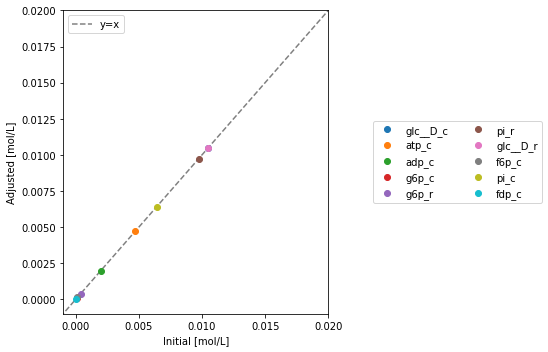

In [87]:
#Compare Results
conc_comparison_fig, ax = plt.subplots(nrows=1, ncols=1,
                                       figsize=(5, 5))

plot_comparison(
    x=conc_df["Concentration(M)"], y=conc_solution,
    compare="concentrations",
    observable=[mid for mid in conc_df.index], ax=ax,
    legend="right outside", plot_function="plot",
    xlim=(-0.001,0.02), ylim=(-0.001,0.02),
    xy_line=True,
    xy_legend="best", xlabel="Initial [mol/L]", ylabel="Adjusted [mol/L]")

conc_comparison_fig.tight_layout()
update_model_with_concentration_solution(
    glycogenolysis, conc_solution, concentrations=True, inplace=True);

## Sample Concentrations

In [88]:
conc_solver.setup_sampling_problem(
    fixed_conc_bounds=list(glycogenolysis.fixed),
    fixed_Keq_bounds=glycogenolysis.reactions.list_attr("Keq_str"))
for variable in conc_solver.variables:
    try:
        met = glycogenolysis.metabolites.get_by_id(variable.name)
        variable.lb, variable.ub = np.log([met.ic / 10, met.ic * 10])
    except:
        pass
conc_samples = sample_concentrations(conc_solver, n=n_models, seed=seed)
conc_samples.head()

,adp_c,atp_c,g6p_c,glc__D_c,f6p_c,fdp_c,pi_c,g6p_r,glc__D_r,pi_r
0,0.000247,0.032517,0.000200,0.030312,0.000359,0.000267,0.002579,0.001520,0.003820,0.003396
1,0.005629,0.009706,0.000626,0.011486,0.001121,0.000019,0.004282,0.003739,0.098470,0.001531
2,0.016212,0.000930,0.000103,0.008049,0.000184,0.000022,0.011179,0.001009,0.005835,0.015365


## Set concentrations and balance models with pseudoreactions

In [89]:
glycogenolysis.boundary_conditions['glc__D_b']=0.010482807 ##  initial condition of the metabolite in the model


In [90]:
glycogenolysis.steady_state_fluxes 

{<MassReaction HEX1 at 0x7fe6824c4390>: 0.0,
 <MassReaction PFK at 0x7fe684548590>: 0.0008284973680377127,
 <MassReaction FBP at 0x7fe6824c9490>: 0.003649512903150023,
 <MassReaction GLCt1 at 0x7fe683a93e50>: -0.0028210155351123104,
 <MassReaction G6Pter at 0x7fe6824c4a90>: 0.0028210155351123104,
 <MassReaction G6PPer at 0x7fe684519cd0>: 0.0028210155351123104,
 <MassReaction GLCter at 0x7fe6824be750>: -0.0028210155351123104,
 <MassReaction PGI at 0x7fe684501610>: -0.0028210155351123104,
 <MassReaction H2Oter at 0x7fe6824be3d0>: 0.0028210155351123104,
 <MassReaction PIter at 0x7fe684530490>: 0.0028210155351123104,
 <MassReaction H2Ot at 0x7fe684501950>: 0.006470528438262334,
 <MassReaction PIt at 0x7fe6824bea10>: 0.006470528438262334,
 <MassReaction Ht at 0x7fe6845234d0>: -0.0008284973680377127}

In [91]:
glycogenolysis.reactions.PGI.stoichiometry


[1.0, -1.0]

In [92]:
glycogenolysis.reactions.PGI  

Reaction identifier,PGI
Name,Glucose-6-phosphate isomerase
Memory address,0x07fe684501610
Subsystem,Glycolysis/gluconeogenesis
Kinetic Reversibility,True
Stoichiometry,g6p_c <=> f6p_c D-Glucose 6-phosphate <=> D-Fructose-6-phosphate
GPR,2821_AT1
Bounds,"(-1000.0, 1000.0)"


In [93]:
# glycogenolysis.steady_state_fluxes.values
glycogenolysis.update_S(array_type="DataFrame")

,HEX1,PFK,FBP,GLCt1,G6Pter,G6PPer,GLCter,PGI,H2Oter,PIter,H2Ot,PIt,Ht
adp_c,1,1,0,0,0,0,0,0,0,0,0,0,0
atp_c,-1,-1,0,0,0,0,0,0,0,0,0,0,0
g6p_c,1,0,0,0,-1,0,0,-1,0,0,0,0,0
glc__D_c,-1,0,0,1,0,0,-1,0,0,0,0,0,0
h_c,1,1,0,0,0,0,0,0,0,0,0,0,1
f6p_c,0,-1,1,0,0,0,0,1,0,0,0,0,0
fdp_c,0,1,-1,0,0,0,0,0,0,0,0,0,0
h2o_c,0,0,-1,0,0,0,0,0,-1,0,1,0,0
pi_c,0,0,1,0,0,0,0,0,0,1,0,-1,0
glc__D_e,0,0,0,-1,0,0,0,0,0,0,0,0,0


In [94]:
# for r, v in glycogenolysis.steady_state_fluxes.items():
#      if not r.boundary:
#         print(r,v)
# for r, v in glycogenolysis.steady_state_fluxes.items():
#      if not (r.boundary or r== glycogenolysis.reactions.GLCter or r==glycogenolysis.reactions.PIter):
#             print(r,v)

In [95]:
transport= [
#  'H2Oter',
    'PIter',
#      'H2Ot',
    'PIt',
#      'Ht',
    'GLCter',
     'G6Pter'
]
for x in transport:
    a=glycogenolysis.reactions.get_by_id(x)
    a.kf=1e6

In [96]:
models_for_ensemble = []
for idx, conc_sample in conc_samples.iterrows():
    # Make copy of new model
    new_model = glycogenolysis.copy()
    new_model.id += "_C{0:d}".format(idx)
    # Get concentration sample and update model with sample
    new_model.update_initial_conditions(conc_sample.to_dict())

    # Determine imbalances in the reduced network
    fluxes = np.array(list(new_model.steady_state_fluxes.values()))
    imbalanced_metabolites = new_model.S.dot(fluxes)

    # Iterate through metabolites
    for mid, imbalance in imbalanced_metabolites.iteritems():
        # Ignore balanced metabolites
        if imbalance == 0 or new_model.metabolites.get_by_id(mid).compartment== "e": # to remove SK_glc__D_e
            continue
        # Get metabolite object
        met = new_model.metabolites.get_by_id(mid)
        # Add boundary reactions for imbalanced metabolites
        boundary_type = "sink"    
        # Add boundary reaction with imbalance as flux value
        boundary_reaction = new_model.add_boundary(
            mid, boundary_type, boundary_condition=met.ic)

        boundary_reaction.Keq = 1
        if imbalance < 0:
            boundary_reaction.reverse_stoichiometry(inplace=True)
            imbalance = -imbalance

        boundary_reaction.kf = imbalance / met.ic
        boundary_reaction.steady_state_flux = imbalance
        try:
            # Update PERCs
            new_model.calculate_PERCs(
                fluxes={
                    r: v for r, v in new_model.steady_state_fluxes.items() 
                    if not (r.boundary or r== new_model.reactions.GLCter or r== new_model.reactions.PIter 
                           or r== new_model.reactions.G6Pter or r== new_model.reactions.PIt)},
                update_reactions=True)
        except:
            print("Negative PERCs for {0}".format(new_model.id))
            percs = new_model.calculate_PERCs(
                fluxes={
                    r: v for r, v in new_model.steady_state_fluxes.items()
                    if not (r.boundary  or r== new_model.reactions.GLCter or r== new_model.reactions.PIter
                           or r== new_model.reactions.G6Pter or r== new_model.reactions.PIt)},
                update_reactions=False)
            print(percs)
            continue
    models_for_ensemble.append(new_model)
print("Number of models in ensemble: {0:d}".format(len(models_for_ensemble)))
# print(models_for_ensemble)

Number of models in ensemble: 3


In [97]:
len(models_for_ensemble)

3

#### Ensure model is in steady state and export

In [98]:
## determine imbalances in the reduced network
fluxes = np.array(list(glycogenolysis.steady_state_fluxes.values()))
imbalanced_metabolites = glycogenolysis.S.dot(fluxes)

# Iterate through metabolites
for mid, imbalance in imbalanced_metabolites.iteritems():
    # Ignore balanced metabolites
    if imbalance == 0 or glycogenolysis.metabolites.get_by_id(mid).compartment== "e": # to remove SK_glc__D_e:
        continue
    # Get metabolite object
    met = glycogenolysis.metabolites.get_by_id(mid)

    # Add boundary reactions for imbalanced metabolites
    boundary_type = "sink"    
    # Add boundary reaction with imbalance as flux value
    boundary_reaction = glycogenolysis.add_boundary(
        mid, boundary_type, boundary_condition=met.ic)

    boundary_reaction.Keq = 1
    if imbalance < 0:
        boundary_reaction.reverse_stoichiometry(inplace=True)
        imbalance = -imbalance

    boundary_reaction.kf = imbalance / met.ic
    boundary_reaction.steady_state_flux = imbalance
    try:
        # Update PERCs
            percs= glycogenolysis.calculate_PERCs(
            fluxes={
                r: v for r, v in glycogenolysis.steady_state_fluxes.items()
                if not (r.boundary  or r== glycogenolysis.reactions.GLCter or r== glycogenolysis.reactions.PIter
                           or r== glycogenolysis.reactions.G6Pter or r== glycogenolysis.reactions.PIt)},
            update_reactions=True)
            print(percs)
    except:
        print("Negative PERCs for {0}".format(new_model.id))
        continue

{'kf_HEX1': 100000.0, 'kf_PFK': 981.9528009153975, 'kf_FBP': 70.91467428479288, 'kf_GLCt1': 0.2691087918568994, 'kf_G6PPer': 7.87647780478302, 'kf_PGI': 16.466946267205028, 'kf_H2Oter': 100000.0, 'kf_H2Ot': 100000.0, 'kf_Ht': 100000.0}
{'kf_HEX1': 100000.0, 'kf_PFK': 981.9528009153975, 'kf_FBP': 70.91467428479288, 'kf_GLCt1': 0.2691087918568994, 'kf_G6PPer': 7.87647780478302, 'kf_PGI': 16.466946267205028, 'kf_H2Oter': 100000.0, 'kf_H2Ot': 100000.0, 'kf_Ht': 100000.0}
{'kf_HEX1': 100000.0, 'kf_PFK': 981.9528009153975, 'kf_FBP': 70.91467428479288, 'kf_GLCt1': 0.2691087918568994, 'kf_G6PPer': 7.87647780478302, 'kf_PGI': 16.466946267205028, 'kf_H2Oter': 100000.0, 'kf_H2Ot': 100000.0, 'kf_Ht': 100000.0}
{'kf_HEX1': 100000.0, 'kf_PFK': 981.9528009153975, 'kf_FBP': 70.91467428479288, 'kf_GLCt1': 0.2691087918568994, 'kf_G6PPer': 7.87647780478302, 'kf_PGI': 16.466946267205028, 'kf_H2Oter': 100000.0, 'kf_H2Ot': 100000.0, 'kf_Ht': 100000.0}
{'kf_HEX1': 100000.0, 'kf_PFK': 981.9528009153975, 'kf_F

In [99]:
# glycogenolysis.reactions.EX_glc__D_e.kf= 1000
for reaction in glycogenolysis.reactions:
    print(reaction.id, reaction.kf)

HEX1 100000.0
PFK 981.9528009153975
FBP 70.91467428479288
GLCt1 0.2691087918568994
G6Pter 1000000.0
G6PPer 7.87647780478302
GLCter 1000000.0
PGI 16.466946267205028
H2Oter 100000.0
PIter 1000000.0
H2Ot 100000.0
PIt 1000000.0
Ht 100000.0
SK_adp_c 0.41529690378643597
SK_atp_c 0.17526375778175401
SK_f6p_c 2.429215599027857e-15
SK_fdp_c 54.808049708010536
SK_h2o_c 8.673617379884035e-19
SK_pi_c 1.355252715606881e-16


In [100]:
## balancing charges on reactions manually

glycogenolysis.metabolites.h_c.charge=1

glycogenolysis.metabolites.h_e.charge=1
# glycolysis.metabolites.h_c.charge=1
# glycolysis.metabolites.h_m.charge=1
# glycolysis.metabolites.h_i.charge=1
glycogenolysis.metabolites.pi_c.charge=-2
glycogenolysis.metabolites.pi_e.charge=-2
# glycolysis.metabolites.pi_m.charge=-2
glycogenolysis.metabolites.pi_r.charge=-2


In [101]:
glycogenolysis.calculate_PERCs(fluxes={
                r: v for r, v in glycogenolysis.steady_state_fluxes.items()
                if not (r.boundary  or r== glycogenolysis.reactions.GLCter or r== glycogenolysis.reactions.PIter
                           or r== glycogenolysis.reactions.G6Pter or r== glycogenolysis.reactions.PIt)}, update_reactions=True)

print("Forward Rate Constants\n----------------------")
for reaction in glycogenolysis.reactions:
    print("{0}: {1:.6f}".format(reaction.kf_str, reaction.kf))

Forward Rate Constants
----------------------
kf_HEX1: 100000.000000
kf_PFK: 981.952801
kf_FBP: 70.914674
kf_GLCt1: 0.269109
kf_G6Pter: 1000000.000000
kf_G6PPer: 7.876478
kf_GLCter: 1000000.000000
kf_PGI: 16.466946
kf_H2Oter: 100000.000000
kf_PIter: 1000000.000000
kf_H2Ot: 100000.000000
kf_PIt: 1000000.000000
kf_Ht: 100000.000000
kf_SK_adp_c: 0.415297
kf_SK_atp_c: 0.175264
kf_SK_f6p_c: 0.000000
kf_SK_fdp_c: 54.808050
kf_SK_h2o_c: 0.000000
kf_SK_pi_c: 0.000000


In [108]:
model= models_for_ensemble[0]
range(len(list(model.genes)))

range(0, 1)

In [109]:
for x in list(range(len(list(model.genes)))):
    a= model.genes[x]
    model.genes.remove(a)

In [110]:
# Whether to print messages as loop occurs. 
verbose = False
# Ensure all models are simulated to a long time and that
# there are enough time points to determine if model reached steady state.
tfinal = 1e4

sim = Simulation(reference_model=models_for_ensemble[0], verbose=verbose)
sim.add_models(models_for_ensemble[1:], verbose=verbose, disable_safe_load=True)
sim.integrator.absolute_tolerance = 1e-15
sim.integrator.relative_tolerance = 1e-9

models_to_export = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for model in models_for_ensemble:
        # Attempt to determine steady state
        conc_sol, flux_sol = sim.find_steady_state(
            models=model, strategy="simulate", update_values=True,
            tfinal=tfinal, 
            verbose=verbose)
        if conc_sol and flux_sol:
            continue
        print(str(model) + " first attempt failed.")
        # First attempt was not successful, lengthen time for second attempt
        # Attempt to determine steady state
        conc_sol, flux_sol = sim.find_steady_state(
            models=model, strategy="simulate", update_values=True,
            tfinal=tfinal * 10, 
            verbose=verbose)
        if conc_sol and flux_sol:
            continue
        print(str(model) + " second attempt failed.")
        # Second attempt was not successful, lengthen time for second attempt
        # Attempt to determine steady state
        conc_sol, flux_sol = sim.find_steady_state(
            models=model, strategy="simulate", update_values=True,
            tfinal=tfinal * 100, 
            verbose=verbose)
        if conc_sol and flux_sol:
            continue
        print(str(model) + " third attempt failed. Eliminating model.")
        # Third attempt was not successful, eliminate the model
        sim.remove_models(models=model, verbose=verbose)

MassSimulationError: Cannot load SBML Model 'Glycogenolysis_C0' 

In [111]:
models_for_ensemble = []
qcqa_model(glycogenolysis, parameters=True, concentrations=True,
          fluxes=True, superfluous=True, elemental=True)


╒══════════════════════════════════════════╕
│ MODEL ID: Glycogenolysis                 │
│ SIMULATABLE: True                        │
│ PARAMETERS NUMERICALY CONSISTENT: True   │
╞══════════════════════════════════════════╡
╘══════════════════════════════════════════╛


In [115]:
# range(len(glycogenolysis.genes))
for x in list(range(len(list(glycogenolysis.genes)))):
    a= glycogenolysis.genes[x]
    glycogenolysis.genes.remove(a)



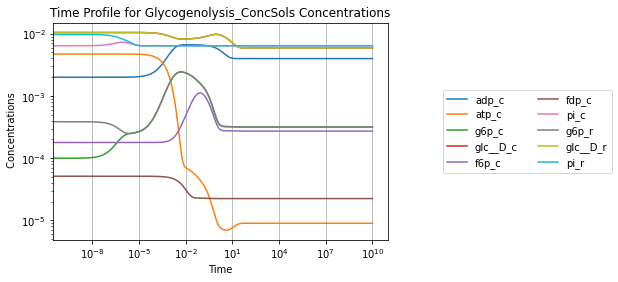

In [116]:
###RUN THIS FOR TIME PROFILE
# Setup simulation object
sim = Simulation(glycogenolysis, verbose=False)
# Simulate from 0 to 1000 with 10001 points in the output
conc_sol, flux_sol = sim.simulate(glycogenolysis, time=(0, 1e10, 1e4 + 1))
# Quickly render and display time profiles
conc_sol.view_time_profile()

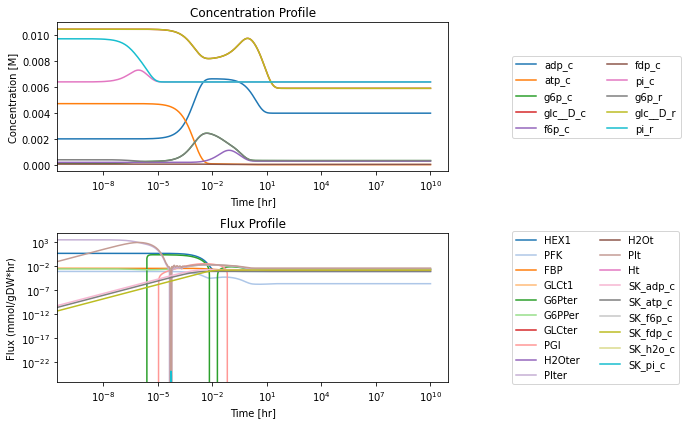

In [117]:
fig_1, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6));
(ax1, ax2) = axes.flatten()
L_FONT = {"size": "large"}
plot_time_profile(
    conc_sol, ax=ax1, legend="right outside",
    plot_function="semilogx",
    xlabel="Time [hr]", ylabel="Concentration [M]",
    title=("Concentration Profile", L_FONT));

plot_time_profile(
    flux_sol, ax=ax2, legend="right outside",
    plot_function="loglog",
    xlabel="Time [hr]", ylabel="Flux (mmol/gDW*hr)",
    title=("Flux Profile", L_FONT));
fig_1.tight_layout()

